# A/B-тест: Изменение позиции рекламного блока

## Цель
Проверить гипотезу, что размещение рекламного блока **над основной лентой** увеличивает конверсию в добавление товаров.

## Ключевая метрика
**CR_add** = (число добавлений из рекламы) / (число кликов на рекламу)

## Гипотеза
Новое размещение **положительно влияет** на CR_add.

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

# Настройки
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)

In [12]:
# Текущая директория: .../finish/notebooks
current_dir = os.path.abspath(os.getcwd())

# BASE_DIR = .../finish (на 1 уровень выше)
BASE_DIR = os.path.abspath(os.path.join(current_dir, '..'))

# Пути к файлам
DATA_RAW = os.path.join(BASE_DIR, "Data", "data_raw.csv")
FINAL_XLSX = os.path.join(BASE_DIR, "Data", "final_results_to_analyze.xlsx")

print(f"📁 Текущая директория: {current_dir}")
print(f"📁 Корень проекта (BASE_DIR): {BASE_DIR}")
print(f"📁 data_raw.csv: {DATA_RAW}")
print(f"📁 final_results_to_analyze.xlsx: {FINAL_XLSX}")

# Проверка существования
if not os.path.exists(DATA_RAW):
    raise FileNotFoundError(f"❌ data_raw.csv не найден: {DATA_RAW}")
if not os.path.exists(FINAL_XLSX):
    raise FileNotFoundError(f"❌ final_results_to_analyze.xlsx не найден: {FINAL_XLSX}")

print("✅ Оба файла найдены.")

📁 Текущая директория: c:\ZC\finish\notebooks
📁 Корень проекта (BASE_DIR): c:\ZC\finish
📁 data_raw.csv: c:\ZC\finish\Data\data_raw.csv
📁 final_results_to_analyze.xlsx: c:\ZC\finish\Data\final_results_to_analyze.xlsx
✅ Оба файла найдены.


In [13]:
# Загрузка
df_raw = pd.read_csv(DATA_RAW, parse_dates=['dt'])

# Нормализация event_type
df_raw['event_type'] = df_raw['event_type'].astype(str).str.lower().str.strip()

# Диагностика
print("Уникальные типы событий:", df_raw['event_type'].unique())
print("\nРаспределение событий:")
print(df_raw['event_type'].value_counts())

# Ожидаемые события (из лога: 'views', 'clicks', 'adds')
required = {'views', 'clicks', 'adds'}
actual = set(df_raw['event_type'])
if not required.issubset(actual):
    raise ValueError(f"❌ Отсутствуют события: {required - actual}")

# Воронка: был ли event хотя бы раз в день
funnel = df_raw.groupby(['dt', 'client_id', 'event_type']).size().unstack(fill_value=0).reset_index()
funnel.columns.name = None

for e in required:
    if e not in funnel.columns:
        funnel[e] = 0

funnel['has_view'] = (funnel['views'] > 0).astype(int)
funnel['has_click'] = (funnel['clicks'] > 0).astype(int)
funnel['has_add'] = (funnel['adds'] > 0).astype(int)

# Агрегация до пользователя
user_hist = funnel.groupby('client_id').agg(
    total_views=('has_view', 'sum'),
    total_clicks=('has_click', 'sum'),
    total_adds=('has_add', 'sum')
).reset_index()

print(f"\nВсего пользователей: {len(user_hist):,}")
print(f"Пользователей с кликами: {len(user_hist[user_hist['total_clicks'] > 0]):,}")

Уникальные типы событий: ['clicks' 'adds' 'views']

Распределение событий:
event_type
views     27006473
clicks      535927
adds        213648
Name: count, dtype: int64

Всего пользователей: 3,102,736
Пользователей с кликами: 228,491


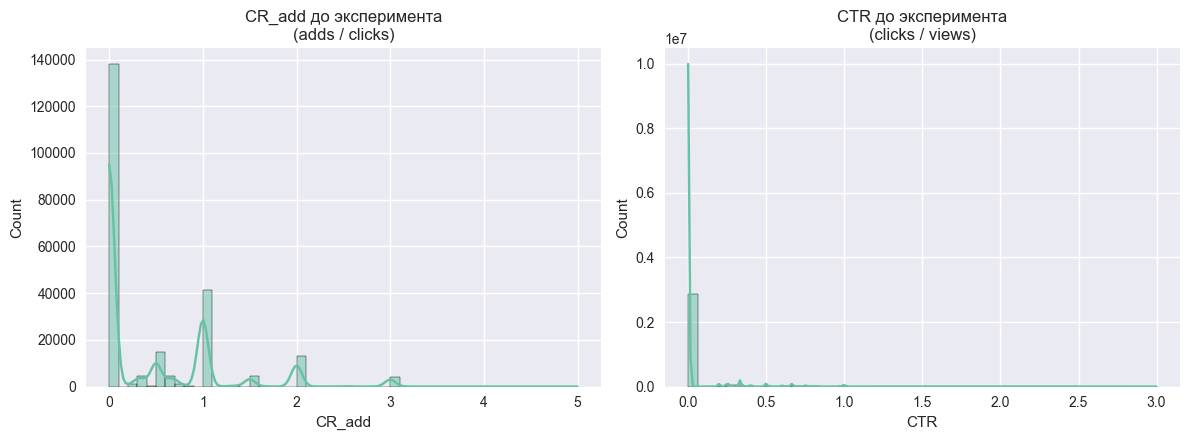

In [14]:
# Подготовка метрик
user_with_clicks = user_hist[user_hist['total_clicks'] > 0].copy()
user_with_clicks['cr_add'] = user_with_clicks['total_adds'] / user_with_clicks['total_clicks']

user_with_views = user_hist[user_hist['total_views'] > 0].copy()
user_with_views['ctr'] = user_with_views['total_clicks'] / user_with_views['total_views']

# Графики
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

sns.histplot(user_with_clicks['cr_add'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('CR_add до эксперимента\n(adds / clicks)')
axes[0].set_xlabel('CR_add')

sns.histplot(user_with_views['ctr'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('CTR до эксперимента\n(clicks / views)')
axes[1].set_xlabel('CTR')

plt.tight_layout()
plt.show()

In [15]:
def var_ratio(x, y):
    mean_x, mean_y = np.mean(x), np.mean(y)
    if mean_y == 0 or len(x) < 2:
        return 0.0
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0, 1]
    return var_x/mean_y**2 + var_y*mean_x**2/mean_y**4 - 2*mean_x*cov_xy/mean_y**3

x = user_with_clicks['total_adds'].values
y = user_with_clicks['total_clicks'].values
mu_cr = np.mean(user_with_clicks['cr_add'])
std_cr = np.sqrt(var_ratio(x, y))

def get_MDE(mu, std, n_total, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1 - alpha/2)
    t_beta = stats.norm.ppf(1 - beta)
    n_per_group = n_total / 2
    mde_abs = (t_alpha + t_beta) * std * np.sqrt(2 / n_per_group)
    return mde_abs / mu * 100

# Таблица MDE
sample_sizes = [20_000, 40_000, 60_000, 80_000, 100_000]
mde_df = pd.DataFrame({
    'Общая выборка': sample_sizes,
    'MDE (%)': [round(get_MDE(mu_cr, std_cr, n), 2) for n in sample_sizes]
})

# Выбор
valid = mde_df[mde_df['MDE (%)'] <= 2.5]
chosen_n = int(valid.iloc[0]['Общая выборка']) if not valid.empty else int(mde_df.iloc[-1]['Общая выборка'])
chosen_mde = mde_df[mde_df['Общая выборка'] == chosen_n].iloc[0]['MDE (%)']

print("Таблица MDE:")
display(mde_df)
print(f"\n✅ Выбрано: {chosen_n:,} пользователей, MDE = {chosen_mde:.2f}%")

Таблица MDE:


,Общая выборка,MDE (%)
0,20000,5.16
1,40000,3.65
2,60000,2.98
3,80000,2.58
4,100000,2.31



✅ Выбрано: 100,000 пользователей, MDE = 2.31%


In [16]:
# Загрузка
df_res = pd.read_excel(FINAL_XLSX)

# Агрегация по пользователю
user_ab = df_res.groupby('client_id').agg(
    ab_group=('ab_group', 'first'),
    has_click=('is_view_ads', 'max'),
    has_add=('is_adds_ads', 'max'),
    revenue=('sum_adds_ads', 'sum'),
    orders=('cnt_orders_ads', 'sum'),
    adds_count=('cnt_adds_ads', 'sum')
).reset_index()

# Агрегация по группам
metrics = user_ab.groupby('ab_group').agg(
    users=('client_id', 'count'),
    clicks=('has_click', 'sum'),
    adds=('has_add', 'sum'),
    revenue=('revenue', 'sum'),
    orders=('orders', 'sum'),
    adds_total=('adds_count', 'sum')
).reset_index()

metrics['CR_add'] = metrics['adds'] / metrics['clicks']
metrics['ARPU'] = metrics['revenue'] / metrics['users']
metrics['CR_order'] = metrics['orders'] / metrics['clicks']
metrics['Avg_check'] = metrics['revenue'] / metrics['adds_total'].replace(0, np.nan)
metrics = metrics.fillna(0)

print("Метрики по группам:")
display(metrics[['ab_group', 'users', 'clicks', 'adds', 'CR_add', 'ARPU', 'CR_order']])

Метрики по группам:


,ab_group,users,clicks,adds,CR_add,ARPU,CR_order
0,control,197578,18997,5705,0.300311,12.436299,0.292730
1,test,197289,19321,5717,0.295896,12.832312,0.305315


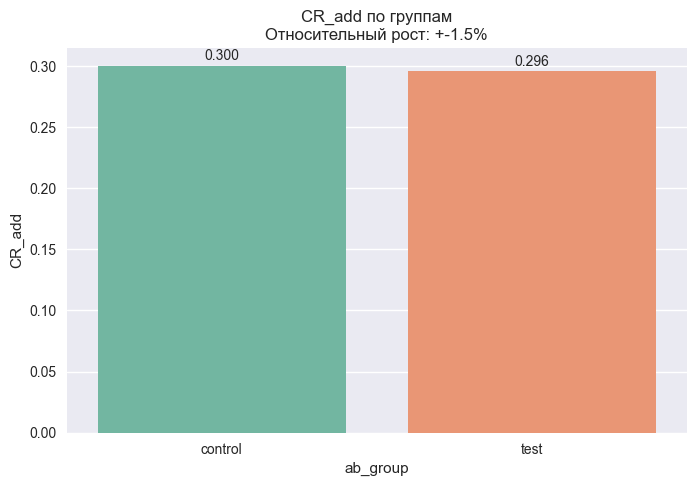


📊 Результаты:
  Контроль (control): CR_add = 0.300
  Тест (test):     CR_add = 0.296
  Относительный рост: +-1.5%
  p-value = 0.1724 → ❌ НЕ значимо


In [18]:
# Определение групп
groups = sorted(metrics['ab_group'].unique())
if len(groups) != 2:
    raise ValueError("Ожидаются ровно 2 группы")

control = metrics[metrics['ab_group'] == groups[0]].iloc[0]
treatment = metrics[metrics['ab_group'] == groups[1]].iloc[0]

cr_diff_rel = (treatment['CR_add'] - control['CR_add']) / control['CR_add'] * 100

# Z-тест
count = np.array([control['adds'], treatment['adds']])
nobs = np.array([control['clicks'], treatment['clicks']])
_, p_val = proportions_ztest(count, nobs, alternative='larger')
is_significant = p_val < 0.05

# Визуализация
plt.figure(figsize=(8, 5))
sns.barplot(
    data=metrics,
    x='ab_group',
    y='CR_add',
    hue='ab_group',        # <-- добавлено
    palette="Set2",
    legend=False           # <-- добавлено
)
plt.title(f'CR_add по группам\nОтносительный рост: +{cr_diff_rel:.1f}%')
for i, row in metrics.iterrows():
    plt.text(i, row['CR_add'] + 0.005, f"{row['CR_add']:.3f}", ha='center')
plt.ylabel('CR_add')
plt.show()

print(f"\n📊 Результаты:")
print(f"  Контроль ({groups[0]}): CR_add = {control['CR_add']:.3f}")
print(f"  Тест ({groups[1]}):     CR_add = {treatment['CR_add']:.3f}")
print(f"  Относительный рост: +{cr_diff_rel:.1f}%")
print(f"  p-value = {p_val:.4f} → {'✅ ЗНАЧИМО' if is_significant else '❌ НЕ значимо'}")